# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [4]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [5]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [8]:
num_agents

20

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [9]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.09599999785423279


When finished, you can close the environment.

In [10]:
import numpy as  np

#Setting random seed for reproducibility
np.random.seed(0) 

import sys
import random

#Setting random seed
random.seed(0)

import torch

#Setting random seed
torch.manual_seed(0)

import torch.nn as nn
from torch.distributions import Normal
import torch.optim as optim
import torch.nn.functional as F

from collections import deque, namedtuple

In [11]:
def init_layers(layer):
    
    """
    Function to calculate the initialization
    values for the weights of the network,
    based on the DDPG paper
    https://arxiv.org/abs/1509.02971
    
    """
    
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    
    return (-lim, lim)


class Actor (nn.Module):
    
    """
    Defines the neural network architecture
    that will be used by the actor
    
    """
    
    
    def __init__(self, state_size, action_size, 
                 hidden_neurons, dropout = 0.1):
        
        """
        Arguments: state_size [Int] (State size),
                   action_size [Int] (Action size),
                   hidden_neurons [List] (Neurons in each hidden layer),
                   dropout [Float from 0 to 1] (Dropout Regularization),
                  
        For example,
        
        agent = Actor(state_size = 33,
                     action_size = 4,
                     hidden_neuron = [128, 64],
                     dropout = 0.1)
                   
        This will create a Actor object which will have
        4 layers: the input layer with 33 neurons; next one hidden layer
        with 128 neurons; next another hidden layer with 64 neurons; final
        output layer with 4 neurons. Except the last layer each layer uses 
        relu as activation and dropout regularization. The last layer uses
        tanh activation to bound the outputs between -1 and 1.
        
        """
        
        super().__init__()
    
        
        # Creating sequence of linear layers
        # that will be applied to input
        
        self.layer1 = nn.Linear(state_size, hidden_neurons[0])
        
        self.layer2 = nn.Linear(hidden_neurons[0], hidden_neurons[1])
        
        self.layer3 = nn.Linear(hidden_neurons[1], action_size)
    
        # Dropout value
        self.dropout = dropout
        
        # Initialize the weights
        self.reset_parameters()
        
        
    def reset_parameters(self):
        
        """
        Initializes the weight of the network
        based on the DDPG paper
        https://arxiv.org/abs/1509.02971
        
        """
        
        self.layer1.weight.data.uniform_(*init_layers(self.layer1))
        self.layer2.weight.data.uniform_(*init_layers(self.layer2))
        self.layer3.weight.data.uniform_(-3e-3, 3e-3)

        
    def forward(self, x):
        
        """
        Arguments: x [Torch Tensor] (state)
        
        Returns:  x [Torch Tensor] (action)
        
        """
        
        # Passing the input through the linear 
        # layers with activations and dropout
        # except the last layer 
        
        x = nn.ReLU()(self.layer1(x))
        
        x = nn.Dropout(self.dropout)(x)
        
        x = nn.ReLU()(self.layer2(x))
        
        x = nn.Dropout(self.dropout)(x)
        
        x = torch.tanh(self.layer3(x))
        
        return x
    
    
class Critic (nn.Module):
    
    """
    Defines the neural network architecture
    that will be used by the critic
    
    """
    
    
    def __init__(self, state_size, action_size, 
                 hidden_neurons, dropout = 0.1):
        
        """
        Arguments: state_size [Int] (State size),
                   action_size [Int] (Action size),
                   hidden_neurons [List] (Neurons in each hidden layer),
                   dropout [Float from 0 to 1] (Dropout Regularization),
                   tanh [Bool] (True for actor to clip actions between -1 to 1)
                   
        For example,
        
        agent = Critic(state_size = 33,
                       action_size = 4,
                       hidden_neuron = [128, 64],
                       dropout = 0.1)
                   
        This will create a model object which will have
        4 layers: the input layer with 33+4 = 37 neurons; next one hidden layer
        with 128 neurons; next another hidden layer with 64 neurons; final
        output layer with 1 neuron.The number of hidden layers and neurons
        in each layer is derived from the length of the list and corresponding
        elements respectively. Except the last layer each layer uses relu as 
        activation and dropout regularization. 
        
        """
        
        
        super().__init__()
        
                
        # Creating sequence of linear layers
        # that will be applied to input
        
        self.layer1 = nn.Linear(state_size + action_size, hidden_neurons[0])
        
        self.layer2 = nn.Linear(hidden_neurons[0], hidden_neurons[1])
        
        self.layer3 = nn.Linear(hidden_neurons[1], 1)

        
        # Dropout value
        self.dropout = dropout
        
        # Initializing network weights
        self.reset_parameters()
        
    def reset_parameters(self):
        
        """
        Initializes the weight of the network
        based on the DDPG paper
        https://arxiv.org/abs/1509.02971
        
        """
        
        self.layer1.weight.data.uniform_(*init_layers(self.layer1))
        self.layer2.weight.data.uniform_(*init_layers(self.layer2))
        self.layer3.weight.data.uniform_(-3e-3, 3e-3)

        
    def forward(self, states, actions):
        
        """
        Arguments: states [Torch Tensor],
                   actions [Torch Tensor]
        
        Returns:  x [Torch Tensor] (Q value)
        
        """
        
        # Concatenates states and action
        
        x = torch.cat([states, actions], dim = -1)
        
        # Passing the input through the linear 
        # layers with activations and dropout
        # except the last layer
        
        x = nn.ReLU()(self.layer1(x))
        
        x = nn.Dropout(self.dropout)(x)
        
        x = nn.ReLU()(self.layer2(x))
        
        x = nn.Dropout(self.dropout)(x)
        
        x = self.layer3(x)
                
        return x
    


In [12]:
class OUNoise():
    
    """
    Ornstein-Uhlenbeck process for temporally
    correlated noise generation
    
    """
    def __init__(self, action_size, 
                 action_low= -1., action_high = 1.,
                 mu=0.0,theta=0.15, max_sigma = 0.2,
                 min_sigma=0.05, decay_period= 5000):
        
        # Initializing process parameters
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.action_dim = action_size
        self.low = action_low
        self.high = action_high
        self.reset()
        
    def reset(self):
        
        """
        Resets the state back to the mean
        
        """
        
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        
        """
        Models the evolution of the state
        
        """
        
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0): 
        
        """
        Returns the action added with noise based
        the current time step
        
        """
        
        ou_state = self.evolve_state()
        # Decreasing standard deviation after each time step
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


In [13]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size 
UPDATE_EVERY = 20       # how often to update the network
NUM_UPDATES = 10        # Number of passes

#Device type (use cuda if gpu is available else cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent(nn.Module):
    
    def __init__(self, state_size, action_size, 
                 hidden_neurons, dropout = 0.1,
                 gamma = 0.99, 
                 learning_rate_actor = 1e-3, 
                 learning_rate_critic = 1e-3,
                 seed = 0, tau = 1e-3):
        
        """
        Arguments: state_size [Int] (State size),
                   action_size [Int] (Number of Actions),
                   hidden_neurons [List] (Neurons in each hidden layer),
                   dropout [Float from 0 to 1] (Dropout Regularization),
                   gamma [Float 0 to 1] (Discounting factor),
                   learning_rate_actor [Float 0 to 1] (Learning rate for weight 
                                                       update for actor),
                   learning_rate_critic [Float 0 to 1] (Learning rate for weight
                                                        update for critic),
                   seed [Int] (random seed),
                   tau [Float from 0 to 1] (Soft update rate for target DQN)
                    
        """
    
        
        super().__init__()
        
        
        # Initializing main actor 
        self.actor_main = Actor(state_size, action_size, 
                              hidden_neurons, dropout).to(device)
        
        # Initializing target actor 
        self.actor_target = Actor(state_size, action_size, 
                              hidden_neurons, dropout).to(device)
        
        # Initializing main critic
        self.critic_main = Critic(state_size, action_size, 
                              hidden_neurons, dropout).to(device)
        
        # Initializing target critic
        self.critic_target = Critic(state_size, action_size, 
                              hidden_neurons, dropout).to(device)
        
        # Optimizer for actor
        self.optimizer_actor = optim.Adam(self.actor_main.parameters(),
                                          lr = learning_rate_actor)
        
        # Optimizer for critic
        self.optimizer_critic = optim.Adam(self.critic_main.parameters(),
                                          lr = learning_rate_critic)
        
        self.gamma = gamma
        
        
        self.tau = tau
        
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        
        self.t_step = 0
        
        
        
    def step(self,state, action, reward, next_state, done):
        
        """
        Arguments: state [Numpy Array] (current state),
                   action [Numpy Array] (action taken at current state)
                   reward  (float) (reward received for current action)
                   next_state [Numpy Array] (next state as a result of current action)
                   done (Bool) (Whether episode has end or not)
        
        """
        
        # Adding experience to replay buffer
        self.memory.add(state, action, reward, next_state, done)
        
        # Keeping track of time step
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        # Updating model weights after 
        # regular intervals
        if self.t_step == 0:
            
            # Checking if enough samples are present
            if len(self.memory) > BATCH_SIZE:
                
                for _ in range(NUM_UPDATES):
                
                    self.learn(self.memory.sample())
                
                
    def act(self, state):
        
        """
        Arguments: state [Torch Tensor] (environment state),
                   
                   
        Returns: Actions [Numpy Array]
        
        """
        
        # Setting the network to evaluation mode
        self.actor_main.eval()
        
        # Using torch no grad as action selection
        with torch.no_grad():
        
            state = torch.from_numpy(state).float().to(device)
            
            action =  self.actor_main(state)
        
            action.clamp_(-1., 1.)
        
        # Setting model for training
        self.actor_main.train()
        
        return action.squeeze(0).cpu().numpy()
    
    
    
    def learn(self,experiences):
        
        """
        Arguments: experience [Tuple]( tuple containing sequence of 
                   state_t, action_t, reward_t, state_t+1, and 
                   each being a Torch Tensor)
                   
        """
        
        # Experiences are fetched from Replay buffer
        states, actions, rewards, next_states, dones = experiences
        

        
        # Setting target network to evaluaion mode
        self.critic_target.eval()
        self.actor_target.eval()
        
        # Creating target value for critic
        with torch.no_grad():
            
            next_actions = self.actor_target(next_states)

            Q_next_state = self.critic_target(next_states, next_actions)
            
            Q_target = rewards + self.gamma*Q_next_state*(1.- dones)
            
            
        # Training Critic
        self.critic_main.train()
        
        # Calculating critic Q value for state and action
        Q_critic = self.critic_main(states, actions)
        
        # Using MSE loss for critic
        critic_loss = F.mse_loss(Q_target, Q_critic).mean()
        
        # Zero grad removes any accumulated gradient
        self.optimizer_critic.zero_grad()
        
        # Calculating gradients using backpropagation
        critic_loss.backward()
        
        # Clipping high gradients
        torch.nn.utils.clip_grad_norm_(self.critic_main.parameters(), 1)
        
        # Updating Weights
        self.optimizer_critic.step()
        
        
        # Calculating critic Q value for state and 
        # actor's action
        actor_loss = -self.critic_main(states,self.actor_main(states)).mean()
        
        # Zero grad removes any accumulated gradient
        self.optimizer_actor.zero_grad()
        
        # Calculating gradients using backpropagation
        actor_loss.backward()
        
        # Clipping high gradients
        torch.nn.utils.clip_grad_norm_(self.actor_main.parameters(), 1)
        
        # Updating Weights
        self.optimizer_actor.step()
        
    
        
        # Updating the target network using soft update through
        # weighted sum of previous parameters and current parameters
        self.soft_update(self.actor_main, self.actor_target)
        
        self.soft_update(self.critic_main, self.critic_target)
        
    
    
                
    def soft_update(self, main_model, target_model):
        
        """
        Arguments: main_model [MLP object]
                   target_model [MLP object]
                   
        Description: updates the weight of the target model 
                     network using weighted sum of previous target model  
                     parameters and current main model parameters 

        """
        
        for target_param, main_param in zip(target_model.parameters(),
                                             main_model.parameters()):
            
            target_param.data.copy_(self.tau * main_param.data + (1.-self.tau) * target_param.data)
    
        
class ReplayBuffer():
    
    """
    Replay Buffer class
    
    """ 
    
    def __init__(self, buffer_size, batch_size, seed=0):
        
        """
        Arguments: buffer_size [Int] (max experience that will be stored,
                   past experiences will be deleted to store new ones),
                   batch_size [Int] (Batch Size for training)
        """
        
      
        # Memory for storing experiences
        self.memory = deque(maxlen = buffer_size)
        
        self.batch_size = batch_size
        
        self.seed = random.seed(seed)
        
        # Storing Experiences as named tuple
        self.experiences =  namedtuple('Experience', 
                                       ['state', 'action', 'reward', 'next_state', 'done'])
    
    
    def add(self, state, action, reward, next_state, done):
        
        """
        Arguments: state [Numpy Array] (current state),
                   action [Numpy Array] (action taken at current state)
                   reward  (float) (reward received for current action)
                   next_state [Numpy Array] (next state as a result of current action)
                   done (Bool) (Whether episode has end or not)
                   
        Description: Adds experience to memory
        
        """
        for i in range(state.shape[0]):
            experience = self.experiences(state[i],
                                          action[i],
                                          reward[i],
                                          next_state[i], 
                                          done[i])
            self.memory.append(experience)

        
    def sample(self):
        
        """
        Returns: Tuple of Torch Tensors containing
                 States, Actions, Rewards, Next States, Dones
                 of specified batch size
        
        """
        
        # Randomly sampling number of experiences equal to batch size
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Stacking the values and converting to tensors
        # to feed in batch
        
        states = (torch.from_numpy(np.vstack([e.state 
                                             for e in experiences if e is not None ]))
                  .float().to(device))
        
        actions = (torch.from_numpy(np.vstack([e.action
                                              for e in experiences if e is not None]))
                   .float().to(device))
        
        rewards = (torch.from_numpy(np.vstack([e.reward 
                                              for e in experiences if e is not None]))
                   .float().to(device))
        
        next_states = (torch.from_numpy(np.vstack([e.next_state 
                                                  for e in experiences if e is not None]))
                       .float().to(device))
                
        dones = (torch.from_numpy(np.vstack([e.done 
                                            for e in experiences if e is not None])
                                 .astype(np.uint8))
                    .float().to(device))
        

  
        return (states, actions, rewards, next_states, dones)
        
    
    def __len__(self):
        
        """
        Dunder Function to return
        length of memory
        
        """
        
        return len(self.memory)
        


In [14]:
# Initializing our agent
agent = Agent(state_size,
              action_size,
              [128, 128])

# Initializing Ornstein-Uhlenbeck process noise
noise  = OUNoise(action_size)

In [12]:
episodes = 1000                                        # Max no. of episodes   
scores = []                                            # list containing scores from each episode
scores_window = deque(maxlen=100)

for i_episode in range(1,episodes+1):
    
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations               # get the current state
    score = np.zeros(num_agents)                       # scores for each agent
    
    noise.reset()
    
    step = 0

    while True:
        
        action = agent.act(state, step)                # select an action
        action = noise.get_action(action, step)        # add noise to action for exploration
        
        env_info = env.step(action)[brain_name]        # send the action to the environment
        
        next_state = env_info.vector_observations      # get the next state
        reward = env_info.rewards                      # get the reward
        done = env_info.local_done                     # see if episode has finished
        agent.step(state, action, reward,              # Update Agent's attributes(Replay buffer/parameters)
                   next_state, done)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        
        step += 1                                      
         
        if np.any(done):                               # exit loop if episode finished is by any agent
            break
        
    scores_window.append(np.mean(score))               # save most recent score
    scores.append(np.mean(score))                      # save most recent score
    
    sys.stdout.flush()
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    
    if np.mean(scores_window) >= 30:
        
        torch.save({'actor_main_network_state_dict':agent.actor_main.state_dict(),
                    'actor_target_network_state_dict':agent.actor_target.state_dict(),
                    'critic_main_network_state_dict':agent.critic_main.state_dict(),
                    'critic_target_network_state_dict':agent.critic_target.state_dict(),
                    'optimizer_actor_state_dict':agent.optimizer_actor.state_dict(),
                    'optimizer_critic_state_dict':agent.optimizer_actor.state_dict()},
                    'agent_state_dict.pt')
        
        if np.mean(scores_window) >= 32:
            
            print("\n Problem Solved!")
            
            break
    
print("Score: {}".format(score))


Episode 141	Average Score: 32.16
 Problem Solved!
Score: [ 32.89999926  26.53999941  28.16999937  25.56999943  31.0999993
  33.49999925  36.27999919  33.04999926  35.17999921  34.54999923
  33.94999924  34.85999922  28.65999936  35.02999922  34.93999922
  35.14999921  28.14999937  28.52999936  35.8399992   35.6599992 ]


In [13]:
%matplotlib inline

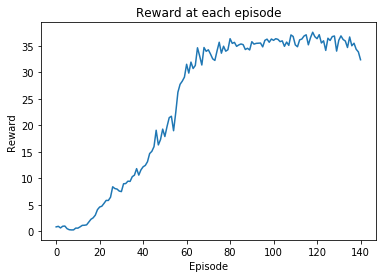

In [14]:
#Plotting Rewards

import matplotlib.pyplot as plt

plt.plot( scores )
plt.title("Reward at each episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.savefig('reward_plot.png')
plt.show()

In [17]:
# Loading saved parameters to test agent over 100 trials

checkpoint = torch.load('agent_state_dict.pt', map_location= "cpu")

agent.actor_main.load_state_dict(checkpoint['actor_main_network_state_dict'])
agent.critic_main.load_state_dict(checkpoint['critic_main_network_state_dict'])

def test():
    
    all_scores = []

    from tqdm import tqdm
    
    for ep in tqdm(range(100)):

        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = agent.act(states)                        # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break

    all_scores.append(np.mean(scores))
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(all_scores)))
    
test()

100%|██████████| 100/100 [09:30<00:00,  5.68s/it]

Total score (averaged over agents) this episode: 38.33499914314598


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 